In [ ]:
import numpy 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, add_remaining_self_loops, degree
import matplotlib.pyplot as plt
from torch.optim import Adam
from math import sqrt
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [ ]:
file_path = "model/gcn.pth"

In [ ]:
%run preprocessing.ipynb
%run temporal_preprocess.ipynb
%run graph.ipynb

In [ ]:
data_ns, adj_matrix_ns, conv_layer_ns = create_graph_pyg_ns(df_filtered, num_neighbors=4, hidden_channels=64)
data_sw, adj_matrix_sw, conv_layer_sw = create_graph_pyg_sw(df_filtered, hidden_channels=64)

In [ ]:
# Graph Convolution Layer
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        self.bias = nn.Parameter(torch.Tensor(output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.sparse.mm(adj, support)
        output = output + self.bias
        return F.relu(output)

# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim1)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2)
        self.gc3 = GraphConvolution(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm(hidden_dim1)
        self.norm2 = nn.LayerNorm(hidden_dim2)

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.norm1(x)
        
        x = self.gc2(x, adj)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.norm2(x)
        
        x = self.gc3(x, adj)
        return x

In [ ]:
def rmse(predictions, targets):
    return sqrt(((predictions - targets) ** 2).mean().item())


def train_gcn_model(model, data, adj_matrix, epochs=150, lr=0.001, accumulation_steps=10, clip_value=1, stop_loss=0.6, save_path=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    mean = data.x.mean(dim=0)
    std = data.x.std(dim=0)
    data.x = (data.x - mean) / std
    losses = []
    rmses = []
    r2_scores = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        accumulated_loss = 0.0

        for i in range(accumulation_steps):
            output = model(data.x, adj_matrix)
            loss = criterion(output.view(-1), data.y)
            loss.backward()
            accumulated_loss += loss.item() / accumulation_steps

        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        losses.append(accumulated_loss)
        if accumulated_loss <= stop_loss:
            print(f"Early stopping as accumulated loss went below stop loss")
            print(f"Epoch {epoch + 1}, Loss : {accumulated_loss}")
            torch.save(model.state_dict(), save_path)
            return (f"Final model saved at {save_path}")
            break
        rmse_val = rmse(output.view(-1), data.y)
        rmses.append(rmse_val)
        r2_val = r2_score(data.y.cpu().numpy(), output.view(-1).detach().cpu().numpy())
        r2_scores.append(r2_val)
        print(f'Epoch {epoch + 1}, Loss: {accumulated_loss}, RMSE: {rmse_val}, R^2: {r2_val}')
    return rmses, losses, r2_scores

Epoch 1, Loss: 2161.0853515625, RMSE: 46.29673789213582, R^2: -2142.388117733131
Epoch 2, Loss: 143.7158889770508, RMSE: 12.317000287965817, R^2: -150.70850607725723
Epoch 3, Loss: 8.280826902389526, RMSE: 2.988314918876912, R^2: -7.930026088711404
Epoch 4, Loss: 1.5730021238327025, RMSE: 1.2343697849598103, R^2: -0.5236689892241178
Epoch 5, Loss: 1.3959659457206726, RMSE: 1.1823894555518581, R^2: -0.39804468299060813
Epoch 6, Loss: 1.290188539028168, RMSE: 1.1367455443275434, R^2: -0.29219026788739644
Epoch 7, Loss: 1.1994545936584473, RMSE: 1.0964869451271868, R^2: -0.20228375958692535
Epoch 8, Loss: 1.1311429977416991, RMSE: 1.0637731777763568, R^2: -0.13161360914369724
Epoch 9, Loss: 1.0817867159843444, RMSE: 1.0394990620574462, R^2: -0.0805582665186495
Epoch 10, Loss: 1.045251190662384, RMSE: 1.0223514531058302, R^2: -0.04520260366522111
Epoch 11, Loss: 1.0214882612228395, RMSE: 1.0105184261297413, R^2: -0.02114746036856885
Epoch 12, Loss: 1.0019840061664582, RMSE: 1.0006935575541

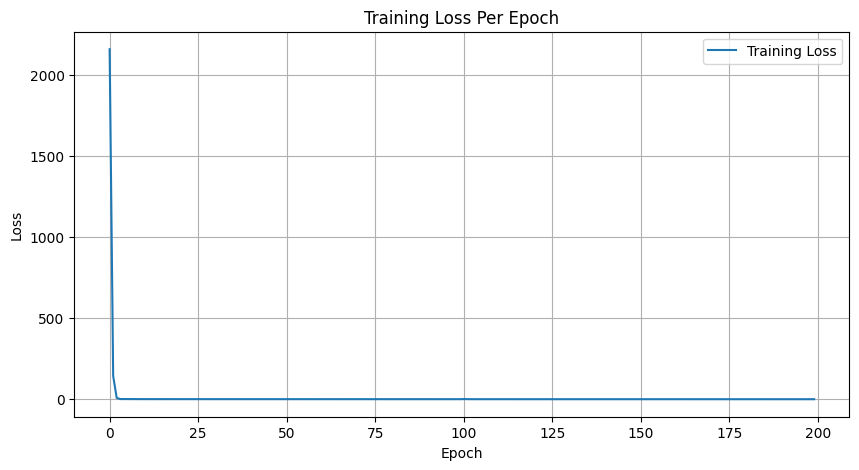

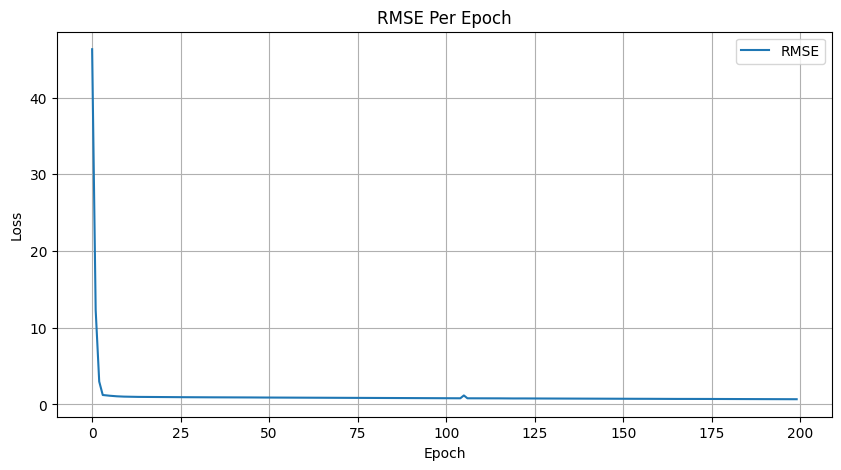

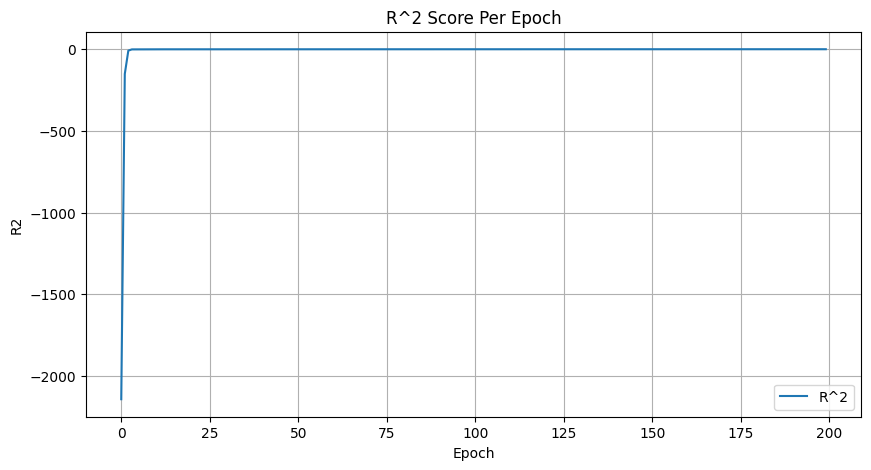

In [30]:
gcn_model = GCN(input_dim=data_ns.x.size(1), hidden_dim1=256, hidden_dim2=256, output_dim=1)
rmses, losses, r2_scores = train_gcn_model(gcn_model, data_ns, adj_matrix_ns, epochs=200, lr=0.001, accumulation_steps=10, clip_value=1, stop_loss=0.4, save_path=file_path)

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(rmses, label='RMSE')
plt.title('RMSE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(r2_scores, label='R^2')
plt.title('R^2 Score Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
gcn_model = GCN(input_dim=data_sw.x.size(1), hidden_dim=512, output_dim=1)
rmses, losses, r2_scores = train_gcn_model(gcn_model, data_sw, adj_matrix_sw, epochs=200, lr=0.001, accumulation_steps=10, clip_value=1, stop_loss=1)

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(rmses, label='RMSE')
plt.title('RMSE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(r2_scores, label='R^2')
plt.title('R^2 Score Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.show()